In [1]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

In [2]:
class BaseSaddle(object):
    def __init__(self, A:np.ndarray):
        self.xopt = None
        self.yopt = None
        self.xrange = None
        self.yrange = None
        self.f = None
        self.g = None 
        self.A = None
        self.F = lambda x, y: self.f(x, y) + x.T @ self.A @ y - self.g(x, y)
        self.dfdx = grad(self.f)
        self.dfdy = 0
        
        self.dgdx = 0
        self.dgdy = grad(self.g, 1) 
        self.dFdx = grad(self.F)
        self.dFdy = grad(self.F, 1)
        # self.d2fdxdx = grad(self.dfdx)
        # self.d2fdydy = 0
        # self.d2fdxdy = grad(self.dfdx, 1)
        # self.d2fdydx = grad(self.dfdy)

    def fr(self, x, y):
        "this is used for the baseline model(follow the ridge)"
        yy = self.d2fdydy(x, y)
        yx = self.d2fdydx(x, y)
        if yy == 0:
            return 0
        return yx/yy
    
    def grad(self, x, y):
        derivs = np.array([self.dFdx(x, y), self.dFdy(x, y)])
        return derivs[0], derivs[1]
    
    def fg_grads(self, x, y):
        derivs = np.array([self.dfdx(x, y), self.dgdy(x, y)])
        return derivs[0], derivs[1]
    
    def loss(self, x, y):
        return (x-self.xopt)**2 + (y-self.yopt)**2

In [93]:
def APDG(problem,
         params: dict,
         x0: np.ndarray,
         y0: np.ndarray,
         iter_num: int
        ):
    x, y = x0.copy(), y0.copy()
    x_f, y_f = x0.copy(), y0.copy()
    y_prev = y0.copy()
    A = problem.A
    
    loss = []
    if problem.xopt is not None:
        xopt, yopt = problem.xopt, problem.yopt
        loss.append(np.sqrt((x-xopt)**2 + (y-yopt)**2))
    x_hist, y_hist = [x], [y]
    
    for i in tqdm(range(iter_num)):
        y_m = y + params['theta'] * (y - y_prev)
        x_g = params['tau_x'] * x + (1 - params['tau_x']) * x_f
        y_g = params['tau_y'] * y + (1 - params['tau_y']) * y_f
        
        grad_x, grad_y = problem.fg_grads(x_g, y_g)
        x = (x + params['eta_x'] * params['alpha_x'] * (x_g - x) -
             params['eta_x'] * params['beta_x'] * (A.T.dot(A.dot(x) - grad_y)) - 
             params['eta_x'] * (grad_x + A.T.dot(y_m))
            )
        y = (y + params['eta_y'] * params['alpha_y'] * (y_g - y) - 
             params['eta_y'] * params['beta_y'] * (A.dot(A.T.dot(y) + grad_x)) -
             params['eta_y'] * (grad_y - A.dot(x))
            )
        x_f = x_g + params['sigma_x'] * (x - x_hist[-1])
        y_f = y_g + params['sigma_y'] * (y - y_hist[-1])
        
        y_prev = y_hist[-1]
        x_hist.append(x)
        y_hist.append(y)
        loss.append(problem.loss(x, y))
    return loss, x_hist, y_hist

In [111]:
def altgd(problem, x0, y0, iteration, lr, k=0):
    x, y = x0.copy(), y0.copy()
    
    xopt, yopt = problem.xopt, problem.yopt
    _x_hist, _y_hist = [], []
    _x_hist.append(x)
    _y_hist.append(y)
    loss = []
    if problem.xopt is not None:
        xopt, yopt = problem.xopt, problem.yopt
        loss.append(np.sqrt((x-xopt)**2 + (y-yopt)**2))
    for i in range(iteration):
        g_x, _ = problem.grad(x,y)
        x = x - lr * g_x
        _, g_y = problem.grad(x,y)
        y = y + lr * g_y
        _x_hist.append(x)
        _y_hist.append(y)
        loss.append(problem.loss(x, y))
    
    return loss, _x_hist, _y_hist

In [110]:
def avg(problem, x0, y0, iteration, lr, k=0):
    x, y = x0.copy(), y0.copy()
    xopt, yopt = problem.xopt, problem.yopt
    loss = []
    if problem.xopt is not None:
        xopt, yopt = problem.xopt, problem.yopt
        loss.append(np.sqrt((x-xopt)**2 + (y-yopt)**2))
    xavg, yavg = x, y
    x_hist, y_hist = [xavg], [yavg]
    for i in range(iteration):
        x = x - lr/np.sqrt(i+1)*(y)
        y = y + lr/np.sqrt(i+1)*(x)        
        xavg = xavg*(i+1)/(i+2) + x/(i+2)
        yavg = yavg*(i+1)/(i+2) + y/(i+2)        
        x_hist.append(xavg)
        y_hist.append(yavg)
        loss.append(problem.loss(xavg, yavg))
    return loss, x_hist, y_hist

In [10]:

class numpyAA:
    def __init__(self, dimension, depth, type2=True,reg=1e-7):
        self._dimension = dimension
        self._depth = depth
        self.xTx = None
        self.reg = reg
        self.Y = np.zeros((self._dimension, self._depth)) # changes in increments
        self.S = np.zeros((self._dimension, self._depth)) # changes in fixed point applications
        self.xTx = np.zeros((self._depth, self._depth))
        self.it = 0
        if type2:
            self.apply = self.type2
        else:
            self.apply = self.type1
        
    def reset(self):
        self.Y = np.zeros((self._dimension, self._depth)) # changes in increments
        self.S = np.zeros((self._dimension, self._depth)) # changes in fixed point applications
        self.xTx = np.zeros((self._depth, self._depth))
        self.it = 0
        
        
    def type2(self, x : np.ndarray, fx : np.ndarray) -> np.ndarray:

        g = x[:,0] -fx[:,0]
        mk = min(self.it, self._depth)
        if (self.it > 0):
            # Build matrices of changes
            col = (self.it -1) % self._depth
            y = g - self.gprev
            self.S[:,col] = x[:,0] - self.xprev[:,0]
            self.Y[:,col] = y
            A = self.Y[:,0:mk].transpose() @ self.Y[:,0:mk]
            b = self.Y[:,0:mk].transpose()@ g
            normS = dnrm2(self._dimension, self.S[:,0:mk],1)
            normY = dnrm2(self._dimension, self.Y[:,0:mk],1)
            reg = normS**2 + normY**2
#             try:
#                 res =  scipy.linalg.lapack.dgesv(A + self.reg * reg * np.eye(mk), b)
#                 gamma_k = res[2]
#             except scipy.linalg.LinAlgError as e:
#                 if 'Singular matrix' in str(e):
            lstsq_solution = linalg.lstsq(A + self.reg  * reg * np.eye(mk), b)
            gamma_k = lstsq_solution[0]
            xkp1 = fx - np.dot(self.S[:,0:mk] - self.Y[:,0:mk], gamma_k)[:, np.newaxis]
            self.it +=1
            self.xprev = x.copy()
            self.gprev = x[:,0] - fx[:,0]

        else:
            xkp1 = fx
            self.it +=1
            self.xprev = x.copy()
            self.gprev = x[:,0] - fx[:,0]
        
        return xkp1
    
    def type1(self, x : np.ndarray, fx : np.ndarray) -> np.ndarray:
        
        
        g = x[:,0] -fx[:,0]
        mk = min(self.it, self._depth)
        if (self.it > 0):
            # Build matrices of changes
            col = (self.it -1) % self._depth
            s = x[:,0] - self.xprev[:,0]
            self.S[:,col] = s
            self.Y[:,col] = g - self.gprev
            A = self.S[:,0:mk].transpose() @ self.Y[:,0:mk]
            b = self.S[:,0:mk].transpose()@ g
            normS = dnrm2(self._dimension, self.S[:,0:mk],1)
            normY = dnrm2(self._dimension, self.Y[:,0:mk],1)
            reg = normS**2 + normY**2
            lstsq_solution = linalg.lstsq(A + self.reg * reg * np.eye(mk), b)
            gamma_k = lstsq_solution[0]
            xkp1 = fx - np.dot(self.S[:,0:mk] - self.Y[:,0:mk], gamma_k)[:, np.newaxis]
            self.it +=1
            self.xprev = x.copy()
            self.gprev = x[:,0] - fx[:,0]
            
        else:
            xkp1 = fx
            self.it +=1
            self.xprev = x.copy()
            self.gprev = x[:,0] - fx[:,0]
        
        return xkp1

In [113]:
gamma = 1e-26 # For 1d problems, you can also set gamma=0.

def altGDAAM(problem, x0, y0, iteration, lr, k, type2=True, reg=1e-10):
    '''
    Proposed Methods: alternating GDA with Anderson Acceleration with numpy
    '''
    x, y = x0, y0
    xopt, yopt = problem.xopt, problem.yopt
    x_hist, y_hist = [x], [y]
    loss = []
    if problem.xopt is not None:
        xopt, yopt = problem.xopt, problem.yopt
        loss.append(np.sqrt((x-xopt)**2 + (y-yopt)**2))
    fp = np.vstack((x, y))
    aa = numpyAA(2, k, type2=type2, reg=reg)
    for i in range(iteration):
        fpprev = np.copy(fp)
        g_x, _ = problem.grad(x,y)
        x_ = (1-gamma) * x - lr * g_x
        _, g_y = problem.grad(x_,y)
        y_ = y + lr * g_y
        fp = np.vstack((x_, y_))
        fp = aa.apply(fpprev, fp)
        x, y = fp[0],fp[1]
        lo = problem.loss(x, y)
        loss.append(lo)
        x_hist.append(x)
        y_hist.append(y)
    return loss, x_hist, y_hist

In [94]:
class func2(BaseSaddle):
    def __init__(self, A):
        super().__init__(A=A)
        self.xopt, self.yopt = 0., 0.   
        self.xrange = [-10, 10, .2]
        self.yrange = [-10, 10, .2]
        self.f = lambda x, y : x**2
        self.g = lambda x, y: y**2
        self.A = A
        self.constraint = False   
        self.dfdx = grad(self.f)  
        self.dgdy = grad(self.g, 1)

In [95]:
def plot(loss, xpath, ypath, iteration, k, start, fig_dir=None):
    x0, y0 = start
    loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8 = loss
    xpath1, xpath2, xpath3, xpath4, xpath5, xpath6, xpath7, xpath8= xpath
    ypath1, ypath2, ypath3, ypath4, ypath5, ypath6, ypath7, ypath8 = ypath
    fig, axlist = plt.subplots(1, 2, figsize=(14,5))
    ax1 = axlist[0]
    ax2 = axlist[1]    
    ax1.contourf(x, y, z, 5, cmap=plt.cm.gray)
    ax1.quiver(x, y, x - dz_dx, y - dz_dy, alpha=.5)
    ax1.plot(xpath7, ypath7,  'm-', linewidth=2, label='SimGDA',markevery=markevery)
    ax1.plot(xpath1, ypath1, 'g--', linewidth=2, label='APDG',markevery=markevery)
    ax1.plot(xpath2, ypath2, '--',linewidth=2, label='AltGD',markevery=markevery)
    ax1.plot(xpath3, ypath3, 'k-^', linewidth=2, label='EG',markevery=markevery)
    ax1.plot(xpath4, ypath4, 'c-*', linewidth=2, label='OMD',markevery=markevery)
    ax1.plot(xpath6, ypath6, 'b->', linewidth=2, label='SimGDA-RAM', markevery=markevery)
    ax1.plot(xpath5, ypath5, 'r-d', linewidth=2, label='AltGDA-RAM', markevery=markevery)
    x_init = ax1.scatter(x0, y0, marker='s', s=250, c='g',alpha=1,zorder=3, label='Start')
    x_sol = ax1.scatter(xsol, ysol, s=250, marker='*', color='violet', zorder=3, label='Optima')
    ax1.legend([x_init, x_sol],['Start','Optima'], markerscale=1, loc=4, fancybox=True, framealpha=1., fontsize=20)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')  
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([ymin,ymax])
    
    plot_interval =1
    # ax2.semilogy(np.arange(0, iteration+plot_interval, plot_interval), loss7[::plot_interval], 'm-', markevery=markevery, label='SimGDA')
    ax2.semilogy(np.arange(0, iteration+plot_interval, plot_interval), loss1[::plot_interval], 'g--', markevery=markevery, label='APDG')
    ax2.semilogy(np.arange(0, iteration+plot_interval, plot_interval), loss2[::plot_interval], '--', markevery=markevery, label='AltGD')
    # ax2.semilogy(np.arange(0, iteration+plot_interval, plot_interval), loss3[::plot_interval], 'k-^', markevery=markevery, label='EG')
    # ax2.semilogy(np.arange(0, iteration+plot_interval, plot_interval), loss4[::plot_interval],'c-*', markevery=markevery, label='OMD')
    # ax2.semilogy(np.arange(0, iteration+plot_interval, plot_interval), loss5[::plot_interval], 'r-d', markevery=markevery, label='SimGDA-RAM')
    ax2.semilogy(np.arange(0, iteration+plot_interval, plot_interval), loss6[::plot_interval], 'b->', markevery=markevery, label='AltGDA-RAM')
    ax2.set_xlabel('Iteration')
    ax2.set_ylim([1e-25,1e4])
    ax2.set_ylabel('Distance to optimal')
    axlist.flatten()[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, framealpha=1., fontsize=20, markerscale=2)
    if fig_dir is not None:
        fig.savefig(os.path.join(fig_dir, figname), dpi=300, bbox_inches = 'tight', pad_inches = 0)
    else:
        fig.savefig(figname, dpi=300, bbox_inches = 'tight', pad_inches = 0)

        
def main(problem, iteration, x0, y0, params, k=5):
    allloss = [[] for _ in  range(8)]
    allxpath = [[] for _ in  range(8)]
    allypath = [[] for _ in  range(8)]
    allloss[0], allxpath[0], allypath[0] = APDG(problem=problem, x0=x0, y0=y0, iter_num=iteration, params=params['apdg'])
    allloss[1], allxpath[1], allypath[1] = altgd(problem, x0, y0, iteration, lr=params['altgd'])
    # allloss[2], allxpath[2], allypath[2] = eg(problem, x0, y0, iteration, lr=lrset['eg'])
    # allloss[3], allxpath[3], allypath[3] = omd(problem, x0, y0, iteration, lr=lrset['omd'])
    # allloss[4], allxpath[4], allypath[4]= simGDAAM(problem, x0, y0, iteration, lr=lrset['AA'], k=k)   
    allloss[5], allxpath[5], allypath[5]= altGDAAM(problem, x0, y0, iteration, lr=params['AA'] ,k=k)   
    # allloss[6], allxpath[6], allypath[6]= simgd(problem, x0, y0, iteration, lr=lrset['simgd'])   
    return allloss, allxpath, allypath

In [96]:
figname = 'APDG_1.png'
FIG_DIR = os.path.join("..", "figures")
if not os.path.exists(FIG_DIR):
    os.mkdir(FIG_DIR)
k = 5
markevery= 10
x0, y0 = np.array([10.]),np.array([10.])
A = np.eye(1, 1)

problem = func2(A=A)
xsol, ysol = problem.xopt, problem.yopt
params = {'apdg': {"eta_x": 0.01,
                   "eta_y": 0.01,
                   "alpha_x": 0.03,
                   "alpha_y": 0.03,
                   "beta_x": 0.02,
                   "beta_y": 0.02,
                   "tau_x": 0.5,
                   "tau_y": 0.5,
                   "sigma_x": 0.01,
                   "sigma_y": 0.01,
                   "theta": 0.1},
          'altgd': 0.1,
          'AA': 0.5
         }
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}
f = problem.f
g = problem.g

type2=True
iteration = 100
loss_f3, xpath_f3, ypath_f3 = main(problem, iteration, x0.copy(), y0.copy(), params, k=k)
xmin, xmax, xstep = [-10, 10, .2]
ymin, ymax, ystep = [-10, 10, .2]
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = lambda x, y: f(x, y) - g(x, y) + x * A * y
z = z(x, y)
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(g, argnum=1)(x, y)
plot(loss_f3, xpath_f3, ypath_f3, iteration, k, [x0, y0], fig_dir=FIG_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1903.97it/s]


## N-dim case

In [98]:
from numpy import linalg as LA
from scipy.linalg import pinv
import numpy.matlib as mt

# create a row vector of given size
def generate_sym(size):
    A = mt.rand(1,size)

# create a symmetric matrix size * size
    symmA = A.T * A
    return symmA

def gen_cond(n, cond):
    """
    Parameters
    ----------
    n : Matrix size
    cond : Condition number
    Returns
    -------
    P : Return a n by n SPD matrix given a condition number
    """
    cond_P = cond     # Condition number
    log_cond_P = np.log(cond_P)
    exp_vec = np.arange(-log_cond_P/4., log_cond_P * (n)/(4 * (n - 1)), log_cond_P/(2.*(n-1)))
    s = np.exp(exp_vec)
    S = np.diag(s)
    U, _ = LA.qr((np.random.rand(n, n) - 5.) * 200)
    V, _ = LA.qr((np.random.rand(n, n) - 5.) * 200)
    P = U.dot(S).dot(V.T)
    P = P.dot(P.T)
    return P

In [108]:
class quad1(object):
    def __init__(self, n, cond = 10, spd=False, bc=False):
        if spd:
            print('spd')
            self.A = gen_cond(n, cond)
        else:
            print('random')
            self.A = np.random.randn(n,n)
        if bc:
            print('bc')
            self.B = np.random.randn(n,1)
            self.C = np.random.randn(n,1)
            self.xtrue = LA.solve(self.A.transpose(), -self.C)
            self.ytrue = LA.solve(self.A, -self.B)    
        else:
            print('bc zeros')
            self.B = np.zeros((n,1))
            self.C = np.zeros((n,1))
            self.xtrue = LA.solve(self.A.transpose(), -self.C)
            self.ytrue = LA.solve(self.A, -self.B)   
        
        self.f = lambda x, y : x.transpose() @ x
        self.g = lambda x, y: y.transpose() @ y

        F =  lambda x,y:  self.f(x, y) - self. g(x, y) + x.transpose() @ self.A @ y + self.B.transpose() @ x + self.C.transpose() @ y 
        self.constraint = False   
        self.dfdx = grad(self.f)  
        self.dgdy = grad(self.g, 1)
        self.dFdx = grad(F)
        self.dFdy = grad(F, 1)   
        self.d2Fdxdx = grad(self.dFdx)
        self.d2Fdydy = grad(self.dFdy, 1)
        self.d2Fdxdy = grad(self.dFdx, 1)
        self.d2Fdydx = grad(self.dFdy)
        self.xopt = None 
        self.yopt = None
    
    
    def fr(self, x, y):
        yx = self.d2Fdydx(x, y)
        return yx
    
    def grad(self, x, y):
        derivs = np.array([self.dFdx(x,y), self.dFdy(x,y)])
        return derivs[0], derivs[1]
    
    def fg_grads(self, x, y):
        derivs = np.array([self.dfdx(x,y), self.dgdy(x,y)])
        return derivs[0], derivs[1]
    
    
    def loss(self, x, y):
        return LA.norm(x-self.xtrue)**2+ LA.norm(y-self.ytrue)**2

In [121]:
problem_n = quad1(n=3, spd=True)
params = {'apdg': {"eta_x": 0.01,
                   "eta_y": 0.01,
                   "alpha_x": 0.03,
                   "alpha_y": 0.03,
                   "beta_x": 0.02,
                   "beta_y": 0.02,
                   "tau_x": 0.5,
                   "tau_y": 0.5,
                   "sigma_x": 0.01,
                   "sigma_y": 0.01,
                   "theta": 0.1},
          'altgd': 0.1,
          'AA': 0.5
         }
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}

x0 = np.random.randn(3, )
y0 = np.random.randn(3, )
type2=True
iteration = 100
k =  10
loss_f3, xpath_f3, ypath_f3 = main(problem_n, iteration, x0.copy(), y0.copy(), params, k=k)

spd
bc zeros


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1797.20it/s]


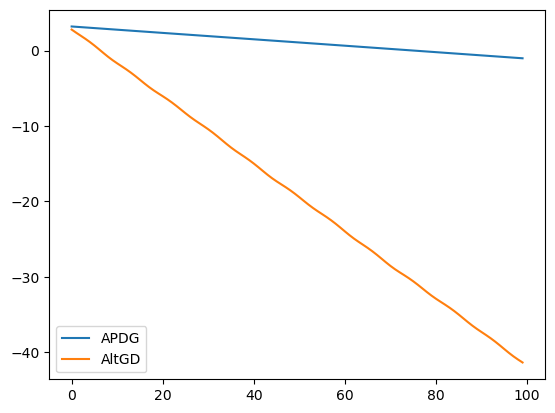

In [131]:
%matplotlib inline
plt.plot(np.log(loss_f3[0]), label="APDG")
plt.plot(np.log(loss_f3[1]), label="AltGD")
# plt.plot(loss_f3[5], label="AltGD-RAM")
plt.legend()